In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
from scipy.stats import norm
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_breast_cancer
from shap import KernelExplainer, Explanation

from lets_plot import *
from lets_plot.bistro import *


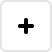
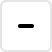
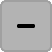
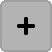
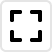
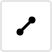
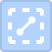
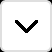
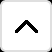
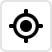
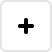
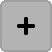
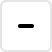
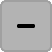
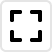
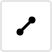
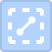
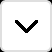
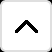
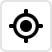

In [2]:
LetsPlot.setup_html()

## Extended Q-Q

In [3]:
# Prepare the data
s = np.random.poisson(5, 100)
smin, smax = float(norm.ppf((1 - .5) / s.size)), float(norm.ppf((s.size - .5) / s.size))

In [4]:
# Q-Q with densities in marginals
ggplot({'s': s}) + \
    geom_qq(aes(sample='s')) + \
    geom_qq_line(aes(sample='s'), color='red') + \
    ggmarginal('l', layer=geom_density(aes(y='s'), orientation='y')) + \
    ggmarginal('b', layer=geom_function(fun=norm.pdf, xlim=[smin, smax], geom='density'))

## SHAP-Waterfall

In [5]:
# Usual waterfall

_DY_NAME = "dy"
_CUMSUM_NAME = "cumsum"
_INITIAL_NAME = "initial"
_DY_TITLE = "Difference"
_CUMSUM_TITLE = "Cumulative sum"
_INITIAL_TITLE = "Initial"
_FLOW_TYPE_TITLE = "Flow type"
_FLOW_TYPE_NAMES = {
    "increase": "Increase",
    "decrease": "Decrease",
    "total": "Total",
}
_FLOW_TYPE_BOX_COLORS = {
    "increase": "#4daf4a",
    "decrease": "#e41a1c",
    "total": "#377eb8",
}
_FLOW_TYPE_TEXT_COLORS = {
    "increase": "#b2df8a",
    "decrease": "#fb9a99",
    "total": "#a6cee3",
}
_FLOW_TYPE_COLOR_VALUE = 'flow_type'

_FILL_DEF = "lightgray"
_SHOW_LEGEND_DEF = False
_TOOLTIPS_DEF = layer_tooltips().title("^x")\
                                .line("{0}|@{1}".format(_INITIAL_TITLE, _INITIAL_NAME))\
                                .line("{0}|@{1}".format(_DY_TITLE, _DY_NAME))\
                                .line("{0}|@{1}".format(_CUMSUM_TITLE, _CUMSUM_NAME))\
                                .disable_splitting()
_SORTED_VALUE_DEF = False
# Total
_CALC_TOTAL_DEF = True
# Horizontal line
_HLINE_DEF = False
_HLINE_ONTOP_DEF = True
# Connector lines
_CONNECTOR_LINES_DEF = True
# Labels
_LABELS_DEF = True
_LABEL_COLOR_DEF = "white"

def _get_stat_data(data, x, y, sorted_value, calc_total, threshold, flow_type_names):
    xs, ys = data[x], data[y]
    assert len(xs) == len(set(xs)), "x values shouldn't contains duplicates"
    if sorted_value:
        xs, ys = zip(*sorted(zip(xs, ys), key=lambda p: abs(p[1]), reverse=True))
    xs = [str(v) for v in xs]
    if threshold is not None:
        other_value = sum([v for v in ys if abs(v) < threshold])
        xs, ys = zip(*[p for p in zip(xs, ys) if abs(p[1]) >= threshold])
        if abs(other_value) > 0:
            xs = list(xs) + ["Other"]
            ys = list(ys) + [other_value]
    cum_sum = 0
    yprev = []
    ynext = []
    ymin = []
    ymax = []
    flow_type = []
    for y_val in ys:
        yprev.append(cum_sum)
        ynext.append(cum_sum + y_val)
        ymin.append(min(cum_sum, ynext[-1]))
        ymax.append(max(cum_sum, ynext[-1]))
        flow_type.append(flow_type_names["increase"] if y_val >= 0 else flow_type_names["decrease"])
        cum_sum = ynext[-1]
    if calc_total:
        xs = list(xs) + [flow_type_names["total"]]
        ys = list(ys) + [cum_sum - ys[0]]
        yprev.append(ys[0])
        ynext.append(cum_sum)
        ymin.append(min(cum_sum, 0))
        ymax.append(max(cum_sum, 0))
        flow_type.append(flow_type_names["total"])
    return {
        'x': xs,
        _INITIAL_NAME: yprev,
        _CUMSUM_NAME: ynext,
        _DY_NAME: ys,
        'ymin': ymin,
        'ymax': ymax,
        _FLOW_TYPE_TITLE: flow_type,
    }

def _get_annotations_data(stat_data):
    n = len(stat_data['x'])
    return {**stat_data,
            **{'y': [(stat_data["ymin"][i] + stat_data["ymax"][i]) / 2 \
                     for i in range(n)],
               'label': [(stat_data[_DY_NAME][i] if i < n - 1 else stat_data[_CUMSUM_NAME][i]) \
                         for i in range(n)]}}

def _get_intermediate_lines(stat_data):
    from itertools import pairwise
    xs = []
    ys = []
    xends = []
    yends = []
    for i, j in list(pairwise(range(len(stat_data['x'])))):
        xs.append(stat_data['x'][i])
        ys.append(stat_data[_CUMSUM_NAME][i])
        xends.append(stat_data['x'][j])
        yends.append(stat_data[_CUMSUM_NAME][i])
    return {
        'x': xs,
        'y': ys,
        'xend': xends,
        'yend': yends,
    }

def waterfall_plot(data, x, y, *, \
                   color=None, fill=_FLOW_TYPE_COLOR_VALUE, size=None, alpha=None, linetype=None, width=None, \
                   show_legend=_SHOW_LEGEND_DEF, tooltips=_TOOLTIPS_DEF, \
                   sorted_value=_SORTED_VALUE_DEF, threshold=None, \
                   calc_total=_CALC_TOTAL_DEF, total_title=None, \
                   hline=_HLINE_DEF, hline_ontop=_HLINE_ONTOP_DEF, hline_color=None, hline_size=None, hline_linetype=None, \
                   connector_lines=_CONNECTOR_LINES_DEF, connector_linetype=None, \
                   labels=_LABELS_DEF, label_color=_LABEL_COLOR_DEF, label_format=None):

    flow_type_names = _FLOW_TYPE_NAMES.copy()
    if total_title is not None:
        flow_type_names['total'] = total_title
    stat_data = _get_stat_data(data, x, y, sorted_value, calc_total, threshold, flow_type_names)
    mapping_dict = {'x': 'x', 'y': _CUMSUM_NAME, 'ymin': 'ymin', 'ymax': 'ymax'}
    if fill == _FLOW_TYPE_COLOR_VALUE:
        mapping_dict['fill'] = _FLOW_TYPE_TITLE
        fill = None

    p = ggplot()
    hline_layer = geom_hline(yintercept=0, color=hline_color, size=hline_size, linetype=hline_linetype, tooltips='none')
    if hline and not hline_ontop:
        p += hline_layer
    if connector_lines:
        p += geom_segment(aes('x', 'y', xend='xend', yend='yend'), \
                          data=_get_intermediate_lines(stat_data), \
                          linetype=connector_linetype, \
                          color=color, size=size, tooltips='none')
    p += geom_crossbar(aes(**mapping_dict), \
                       data=stat_data, \
                       fatten=0, \
                       color=color, fill=fill, size=size, alpha=alpha, linetype=linetype, \
                       width=width, \
                       show_legend=show_legend, tooltips=tooltips)
    if hline and hline_ontop:
        p += hline_layer
    if labels:
        labels_mapping_dict = {'x': 'x', 'y': 'y', 'label': 'label'}
        color_is_mapped = label_color == _FLOW_TYPE_COLOR_VALUE
        if color_is_mapped:
            labels_mapping_dict['color'] = _FLOW_TYPE_TITLE
            label_color = None
        p += geom_text(aes(**labels_mapping_dict), \
                       data=_get_annotations_data(stat_data), \
                       color=label_color, label_format=label_format, show_legend=(show_legend and color_is_mapped))
    actual_flow_type_names = list(flow_type_names.keys())
    if not calc_total:
        actual_flow_type_names.remove('total')
    return p + \
        scale_fill_manual(values={flow_type_names[k]: _FLOW_TYPE_BOX_COLORS[k] for k in actual_flow_type_names}) + \
        scale_color_manual(values={flow_type_names[k]: _FLOW_TYPE_TEXT_COLORS[k] for k in actual_flow_type_names})

In [6]:
# Example origin: https://stackoverflow.com/a/72438597

# Prepare data
X, y = load_breast_cancer(return_X_y=True, as_frame=True)

# Fit model
idx = 9
model = LogisticRegression().fit(X, y)

# Get SHAP values
explainer = KernelExplainer(model.predict, X)
shap_values = explainer.shap_values(X.loc[[5]])
shap_data = {'vars': list(X.columns), 'values': list(shap_values[0])}

Using 569 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.23s/it]


In [7]:
waterfall_plot(shap_data, 'vars', 'values', threshold=.05, label_format=".2f")